In [1]:
import sys, itertools, re, sqlite3, math, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Normalization
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Markdown
from PIL import Image

In [2]:
rcParams["figure.figsize"] = (18,8)
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
current_path = os.getcwd()
sys.path.append(current_path)

# enable to get always the same result model
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

NUM_OF_CATEGORIES = 4
EPOCHS = 3000

feature_column = "k_rechtsvorm,k_sbi1,k_sbi2,k_sbi3,j_account,j_subcat,j_bedrag,c_investeringsverw,c_beursontwikkeling,m_M,m_UM,m_TA,r_bestaan,r_voorkomen,r_volledigheid,r_nauwkeurigheid,r_waardering,r_afgrenzing,r_classificatie,r_presentatie,r_rechten_en_verplichtingen"
feature_names = feature_column.split(',')
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []
y_test = []
conn = sqlite3.connect(os.path.join(current_path,"tmp","save.db3"))
curr = conn.cursor()
curr.execute(f"Select {feature_column},result,set_type FROM DataSet")
label_size_cor = None
for row in curr.fetchall():
    label_size_cor = (len(feature_names),len(row)-2)
    if row[-1] == "training":
        X_train.append(row[:-2])
        y_train.append(row[-2])
    if row[-1] == "valid":
        X_valid.append(row[:-2])
        y_valid.append(row[-2])
    if row[-1] == "test":
        X_test.append(row[:-2])
        y_test.append(row[-2])
conn.close()
#print("Are the labels correct? => ",label_size_cor)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

from keras import utils
y_nosparse_train = utils.to_categorical(y_train, NUM_OF_CATEGORIES)
y_nosparse_valid = utils.to_categorical(y_valid, NUM_OF_CATEGORIES)
y_nosparse_test = utils.to_categorical(y_test, NUM_OF_CATEGORIES)

(10572, 21) (10572,)
(1760, 21) (1760,)
(1764, 21) (1764,)


In [3]:
def make_matrix(data_set, feature_col):
    features = feature_col.split(",")
    dim = int(math.ceil(math.sqrt(len(features))))
    w = dim 
    h = dim
    
    res_set = []
    for row in data_set:
        m = np.zeros((w, h, 1), dtype=np.float32)
        for i, num in enumerate(row):
            m[i % w][int(i / w)][0] = np.float32(num)
        res_set.append(m)

    from PIL import Image
    im = Image.fromarray(np.squeeze(res_set[0], axis=2), 'L')
    im.save("test.png")
    return np.array(res_set)

In [4]:
X_train_2d = make_matrix(X_train, feature_column)
X_valid_2d = make_matrix(X_valid, feature_column)
X_test_2d = make_matrix(X_test, feature_column)

In [5]:
model = Sequential()
# cnn layers
model.add(Conv2D(16, (3,3),1, batch_input_shape=X_train_2d.shape, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Conv2D(32, (1,1),1, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Conv2D(16, (3,3),1, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())
model.add(Dense(units=64, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(Dropout(0.2))
# output layer
model.add(Dense(units=NUM_OF_CATEGORIES, activation='softmax',activity_regularizer=tf.keras.regularizers.l1(0.001)))
# compile and fit
model.compile(loss=tf.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(name="accuracy"), 
                  tf.keras.metrics.Precision(name="precision"), 
                  tf.keras.metrics.Recall(name="recall")
              ])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)
]
h = model.fit(X_train_2d, y_nosparse_train, epochs=EPOCHS, batch_size=64, validation_data=(X_valid_2d, y_nosparse_valid),callbacks=callbacks)
e = model.evaluate(X_test_2d, y_nosparse_test, verbose=2)

Epoch 1/3000


I0000 00:00:1715342414.962263  329393 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 2s 6ms/step - loss: 1.3927 - accuracy: 0.2660 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3886 - val_accuracy: 0.3614 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3000
42/42 [==============================] - 0s 2ms/step - loss: 1.3852 - accuracy: 0.2978 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3761 - val_accuracy: 0.3545 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/3000
42/42 [==============================] - 0s 2ms/step - loss: 1.3559 - accuracy: 0.3466 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3428 - val_accuracy: 0.3682 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/3000
42/42 [==============================] - 0s 3ms/step - loss: 1.3272 - accuracy: 0.3874 - precision: 0.4000 - recall: 7.5672e-04 - val_loss: 1.3241 - val_accuracy: 0.4227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/3000
42/42 [==============================] - 0s 

<h2>Convolutional Neural Network (CNN)</h2>

Loss: 0.61
Accuracy: 79%
Precision: 0.81
Recall: 0.77


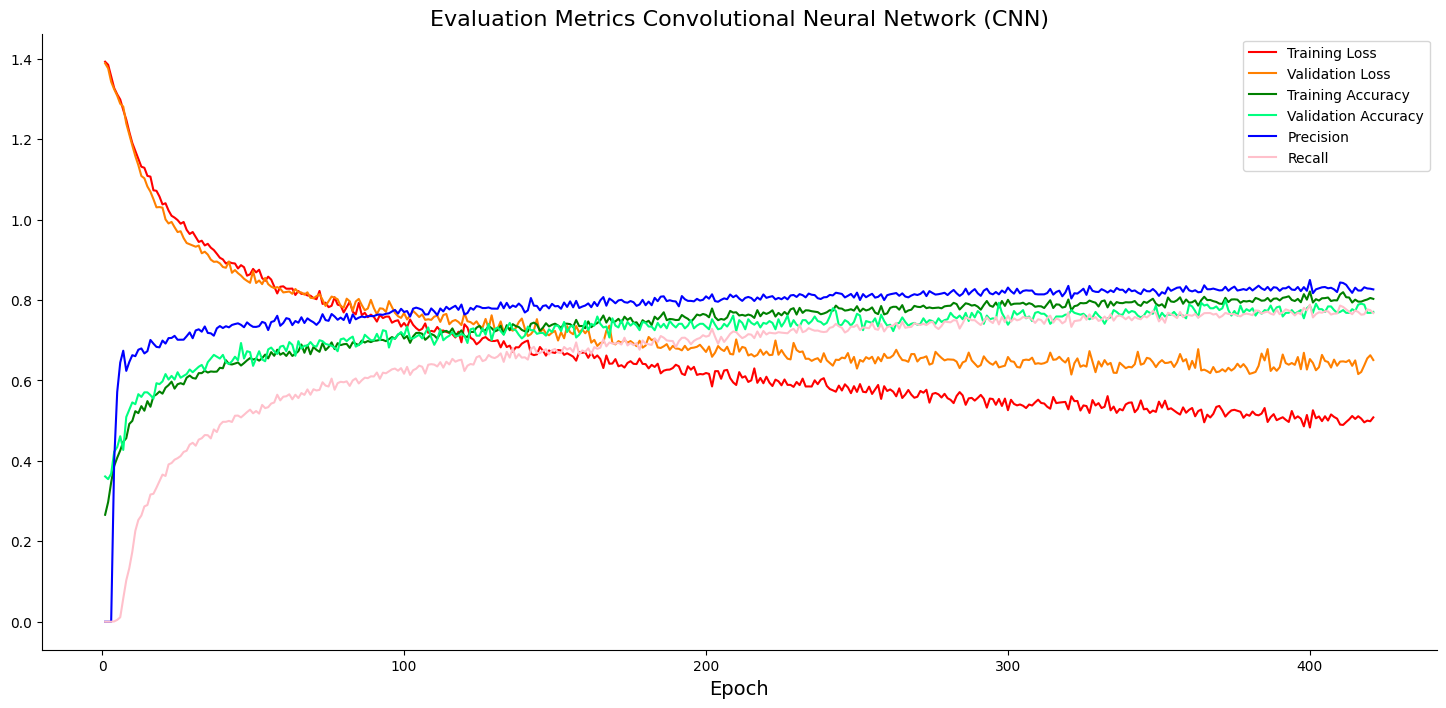

In [6]:
name = "Convolutional Neural Network (CNN)"

display(Markdown(f'<h2>{name}</h2>'))
print(f'Loss: {e[0]:.2f}')
print(f'Accuracy: {int(e[1] * 100)}%')
print(f'Precision: {e[2]:.2f}')
print(f'Recall: {e[3]:.2f}')

range_epochs = np.arange(1, len(h.history['loss'])+1)
plt.figure(0)
plt.plot(range_epochs, h.history['loss'], label='Training Loss',color='red')
plt.plot(range_epochs, h.history['val_loss'], label='Validation Loss',color='#ff8000')
plt.plot(range_epochs, h.history['accuracy'], label='Training Accuracy',color='green')
plt.plot(range_epochs, h.history['val_accuracy'], label='Validation Accuracy',color='#00ff80')
plt.plot(range_epochs, h.history['precision'], label='Precision',color='blue')
plt.plot(range_epochs, h.history['recall'], label='Recall',color='pink')

plt.title(f"Evaluation Metrics {name}", size=16)
plt.xlabel("Epoch", size=14)
plt.legend()
plt.show()

In [7]:
test_set = []
res_set = []

con2 = sqlite3.connect(os.path.join(current_path,"tmp","save.db3"))
cur2 = con2.cursor()
cur2.execute(f"Select {feature_column},result FROM DataSet")
rows = cur2.fetchall()
parameters = [[float(item or 0) for item in row[:-1]] for row in rows]
expected = [int(row[-1]) for row in rows]
con2.close()

print("Outcome diversity: ", expected.count(0),expected.count(1),expected.count(2),expected.count(3))

test_valid = make_matrix(parameters, feature_column)
predicted = model.predict(test_valid)
predicted = tf.squeeze(predicted)
predicted = [list(x).index(max(list(x))) for x in predicted]
check = []
for idx, res in enumerate(expected):
    check.append(predicted[idx]==res)
print("Number of wrong:", check.count(False), "out of", len(check))

Outcome diversity:  3524 3524 3524 3524
441/441 [==============================] - 0s 548us/step
Number of wrong: 2056 out of 14096
